# Train script for RNN VAE model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
import torch

import sys
sys.path.append("../../Modules")
sys.path.append("../../Datasets")

# local imports
from train import train
from helpers import kl_loss,nll_loss,mse_loss,kl_loss_multi
from models import RNNVAE
from ToyDatasets.timeSeries import Sinusoids

## Define dataset loader

In [2]:
batch_size = 32
num_steps = 16
dataset_size = 5000
num_classes = 10

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)
valid_data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size,quantization=num_classes),batch_size=batch_size,shuffle=True)

batch_loader = iter(data_loader)
valid_batch_loader = iter(valid_data_loader)

## Define model

In [3]:
model = RNNVAE(input_size=1,rnn_size=256,latent_size=64,output_size=num_classes,use_softmax=True)
print("Number of trainable parameters {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# test forward pass
try:
    initial_batch = batch_loader.next()
    x = Variable(initial_batch).type(torch.FloatTensor).transpose(1,0)
    test,_ = model(x)
    assert (test.shape[0] == x.shape[0] and test.shape[1] == x.shape[1] and test.shape[2] == num_classes)
    print("Forward pass succesfull")
except:
    print("Error in forward pass. Output should have shape: {} but had {}".format(x.contiguous().view(-1).shape,test.view(-1).shape))

Number of trainable parameters 646538
Forward pass succesfull


## Define optimizer and loss

In [4]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,verbose=True,cooldown=5)

## Run trainer


Train (1 2%) elbo: -2.1489 r_loss: -2.1489 kl: 5.5071 aux_loss: 0.0000 beta 0.00e+00
Valid (1 2%) elbo: -2.0463 r_loss: -2.0463 kl: 10.2999 aux_loss: 0.0000 beta 0.00e+00

Train (2 4%) elbo: -1.9153 r_loss: -1.9123 kl: 14.7741 aux_loss: 0.0000 beta 2.04e-04
Valid (2 4%) elbo: -2.0242 r_loss: -2.0200 kl: 20.9142 aux_loss: 0.0000 beta 2.04e-04

Train (3 6%) elbo: -1.6155 r_loss: -1.5981 kl: 42.6120 aux_loss: 0.0000 beta 4.08e-04
Valid (3 6%) elbo: -1.6692 r_loss: -1.6453 kl: 58.3501 aux_loss: 0.0000 beta 4.08e-04

Train (4 8%) elbo: -1.4763 r_loss: -1.4447 kl: 51.6202 aux_loss: 0.0000 beta 6.12e-04
Valid (4 8%) elbo: -1.5058 r_loss: -1.4765 kl: 47.7811 aux_loss: 0.0000 beta 6.12e-04

Train (5 10%) elbo: -1.4167 r_loss: -1.3754 kl: 50.5020 aux_loss: 0.0000 beta 8.16e-04
Valid (5 10%) elbo: -1.2894 r_loss: -1.2461 kl: 53.0239 aux_loss: 0.0000 beta 8.16e-04

Train (6 12%) elbo: -1.3204 r_loss: -1.2701 kl: 49.2993 aux_loss: 0.0000 beta 1.02e-03
Valid (6 12%) elbo: -1.3720 r_loss: -1.3308 kl


Train (48 96%) elbo: -0.9482 r_loss: -0.6399 kl: 32.1395 aux_loss: 0.0000 beta 9.59e-03
Valid (48 96%) elbo: -0.9785 r_loss: -0.6533 kl: 33.9015 aux_loss: 0.0000 beta 9.59e-03

Train (49 98%) elbo: -0.9488 r_loss: -0.6377 kl: 31.7519 aux_loss: 0.0000 beta 9.80e-03
Epoch    48: reducing learning rate of group 0 to 2.5000e-05.
Valid (49 98%) elbo: -1.0120 r_loss: -0.6884 kl: 33.0368 aux_loss: 0.0000 beta 9.80e-03

Train (50 100%) elbo: -0.9576 r_loss: -0.6446 kl: 31.3031 aux_loss: 0.0000 beta 1.00e-02
Valid (50 100%) elbo: -0.8941 r_loss: -0.5785 kl: 31.5606 aux_loss: 0.0000 beta 1.00e-02


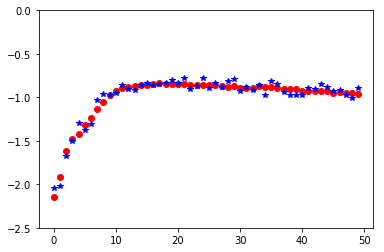

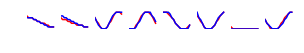

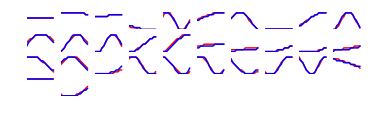

In [5]:
# use at least 50 iterations to get good results
train(data_loader,valid_batch_loader,model,optimizer,scheduler,nll_loss,kl_loss,n_iters=50,use_softmax=True,print_every=1,plot_pred=True)

In [9]:
torch.save(model.state_dict(),"../../Saved_models/ToyDataset/RNNVAE_nll.pt")